In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout   
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import roc_auc_score, roc_curve

df=pd.read_csv("mimic_ca_baseline_total_v2.csv")   

df=df.drop(['subject_id'],axis=1)
df=df.drop(['hadm_id'],axis=1)
df=df.drop(['stay_id'],axis=1)
df=df.drop(['los'],axis=1)

#df=df.drop(['CA'],axis=1)
#df=df.drop(['hospDIED'],axis=1)
#df=df.drop(['cardR'],axis=1)
#df=df.drop(['DNR'],axis=1)
#df=df.drop(['CMO'],axis=1)
#df=df.drop(['DNRDNI'],axis=1)

#df=df.drop(['DNI'],axis=1)
#df=df.drop(['FullCode'],axis=1)
#df=df.drop(['indextime'],axis=1)
#df=df.drop(['ccs9'],axis=1)
#df=df.drop(['ccs10'],axis=1)
#df=df.drop(['cardRv2'],axis=1)

###############CXR##############
#df=df.drop(['Atelectasis'],axis=1)
#df=df.drop(['Cardiomegaly'],axis=1)
#df=df.drop(['Consolidation'],axis=1)
#df=df.drop(['Edema'],axis=1)
#df=df.drop(['Enlarged Cardiomediastinum'],axis=1)
#df=df.drop(['Fracture'],axis=1)
#df=df.drop(['Lung Lesion'],axis=1)
#df=df.drop(['Lung Opacity'],axis=1)
#df=df.drop(['No Finding'],axis=1)
#df=df.drop(['Pleural Effusion'],axis=1)
#df=df.drop(['Pleural Other'],axis=1)
#df=df.drop(['Pneumonia'],axis=1)
#df=df.drop(['Pneumothorax'],axis=1)
#df=df.drop(['Support Devices'],axis=1)
###############CXR##############

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

random=32
smote_ratio=1

#df=pd.get_dummies(data=df,columns=["first_careunit","ethnicity","BMI"])
df=pd.get_dummies(data=df,columns=["first_careunit","ethnicity"])

df_train=df[:21540]
df_test=df[21540:]

#print(df.columns)

y_train=df_train['eventV3']
y_test=df_test['eventV3'].values

df_train=df_train.drop(['eventV3'],axis=1)
train_features=df_train.values
df_test=df_test.drop(['eventV3'],axis=1)
test_features=df_test.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

X_train=minmax_scale.fit_transform(train_features)
X_test=minmax_scale.fit_transform(test_features)

#X_train=train_features
#X_test=test_features

sm = SMOTE(random_state=random,sampling_strategy=smote_ratio)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

#nr = NearMiss(sampling_strategy=0.35) 
#X_train, y_train = nr.fit_sample(X_train, y_train.ravel())

print(X_train.shape)
print(X_test.shape)

print(y_train)
print(y_test)
print(y_train.shape)
print(y_test.shape)


Using TensorFlow backend.


(42320, 70)
(5384, 70)
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
(42320,)
(5384,)


In [2]:
import sklearn

sklearn.__version__

'0.23.2'

In [3]:
import tensorflow as tf

tf.__version__

'2.1.0'

In [4]:
import keras 
keras.__version__

'2.3.1'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn import model_selection

gbm = xgb.XGBClassifier()

xgb_params = {
#'learning_rate': [0.1,0.2,0.5],
#'n_estimators': [30,50,100],
#'max_depth': [5,10,20],
'n_estimators': [3,4,5],
'max_depth': [3,4,5]
#'n_estimators': [3],
#'max_depth': [3]
#'n_estimators': [5],
#'max_depth': [30]
#'n_estimators': [30],
#'max_depth': [5]
#'n_estimators': [30],
#'max_depth': [30]
# 'alpha': [0.4,0.6],
 }

xg_reg = model_selection.GridSearchCV(gbm, xgb_params, cv=5,scoring="roc_auc")
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)
y_pred_xg = xg_reg.predict_proba(X_test)
y_pred_xg = y_pred_xg[:, 1]

In [6]:
predict_test=[]
for i in range(y_pred_xg.shape[0]): 
    if y_pred_xg[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(5384)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

fpr,tpr,roc_auc = roc_curve_and_score(y_test, y_pred_xg) ###計算真正率和假正率
accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

print('AUC : %0.2f' % roc_auc)  #AUC

print('accuracy :%0.2f' % accuracy)


print(xg_reg.best_params_)
print(xg_reg.best_score_)

Confusion Matrix : 
 [[4861  428]
 [  42   53]]
Sensitivity : 0.56
Specificity :0.92
AUC : 0.85
accuracy :0.91
{'max_depth': 5, 'n_estimators': 5}
0.9781742969668491


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
#'n_estimators': [5],
#'max_depth': [5]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest_fit=forest.fit(X_train,y_train)


prob_predict_y_validation = forest.predict_proba(X_test)#给出带有概率值的结果，每个点所有label的概率和为1
y_score = prob_predict_y_validation[:, 1]


In [8]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(5384)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

fpr,tpr,roc_auc = roc_curve_and_score(y_test, y_score) ###計算真正率和假正率

print('AUC : %0.2f' % roc_auc)  #AUC

print('accuracy :%0.2f' % accuracy)

print(forest.best_params_)
print(forest.best_score_)

Confusion Matrix : 
 [[4943  346]
 [  48   47]]
Sensitivity : 0.49
Specificity :0.93
AUC : 0.86
accuracy :0.93
{'max_depth': 7, 'n_estimators': 20}
0.931828922495274


In [9]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
def ROC(label, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param label: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_th, optimal_point
    """
    fpr, tpr, thresholds = metrics.roc_curve(label, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point


In [10]:
def Find_Optimal_Cutoff_1(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [11]:
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff_1(y_test, y_score)
print (threshold)

predict_test_new=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>threshold:
        predict_test_new.append(1)
    else:
        predict_test_new.append(0)
predict_test_new = np.array(predict_test_new)


[0.3397275956169366]


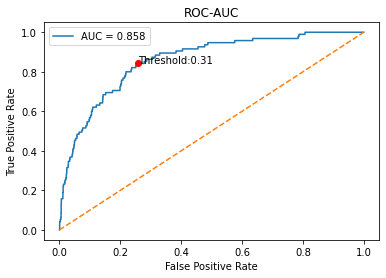

In [12]:
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(y_test, y_score)

plt.figure(1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
log_test_y_predicted = logreg.fit(X_train, y_train).decision_function(X_test)

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [14]:
logreg_test_y_predicted = logreg.predict(X_test)
predict_test=[]
for i in range(logreg_test_y_predicted.shape[0]): 
    if logreg_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.799777
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4231,1058
1,20,75


In [15]:
logreg_test_y_predicted_pro = logreg.predict_proba(X_test)

log_score = logreg_test_y_predicted_pro[:, 1]

predict_test=[]
for i in range(log_score.shape[0]): 
    if log_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.799777
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4231,1058
1,20,75


In [16]:
from sklearn.linear_model import LogisticRegressionCV

logregCV = LogisticRegressionCV(cv=5)
logregCV.fit(X_train, y_train)


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegressionCV(cv=5)

In [17]:
logreg_test_y_predicted_pro_CV = logregCV.predict_proba(X_test)

log_score_CV = logreg_test_y_predicted_pro_CV[:, 1]

predict_test_CV=[]
for i in range(log_score_CV.shape[0]): 
    if log_score_CV[i]>0.5:
        predict_test_CV.append(1)
    else:
        predict_test_CV.append(0)
predict_test_CV = np.array(predict_test_CV)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test_CV)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test_CV))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test,predict_test_CV,rownames=['label'],colnames=['predict'])

Accuracy: 0.799963
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4232,1057
1,20,75


In [42]:
df_column=["cardiac tamponade","severe sepsis","congertive_heart_failure","cardiomegaly","first_careunit_CCU","acidosis"
           ,"renal_failure","age","spontaneous tension pneumothorax","respiratory failure"]

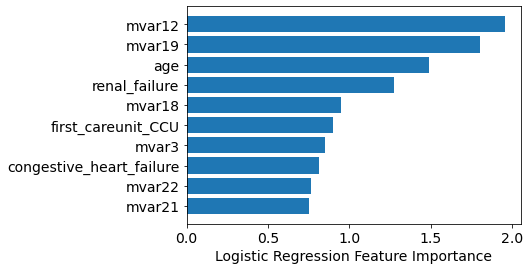

In [43]:
importance = logregCV.coef_[0]
sorted_idx_lr=importance.argsort()
top_10_lr=sorted_idx_lr[60:]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh(df_train.columns[top_10_lr], importance[top_10_lr])
plt.xlabel("Logistic Regression Feature Importance")
plt.show()

In [48]:
importance

array([ 1.49194639e+00, -3.18966086e-01,  8.14460974e-01,  3.71405998e-02,
        3.47277387e-01,  3.21375971e-01,  4.24425124e-01, -8.60485157e-01,
       -1.75455082e+00, -3.85508241e-02,  4.69402009e-01, -6.59332270e-02,
        2.07783252e-01, -7.12567891e-02,  2.65909095e-01,  1.27685064e+00,
        4.21672475e-01,  1.91733763e-01, -7.99111569e+00, -1.02152432e+00,
        3.43987782e-02, -4.38722176e-01, -2.78409857e-01,  3.30741816e-02,
       -1.82668101e-02, -4.05510455e-01,  3.77332785e-01, -1.26125692e+00,
       -6.11990025e-01, -7.28538058e-02, -4.45956354e-01, -3.21116599e-01,
       -6.96051917e-01, -1.60807257e-01,  6.27698787e-01,  8.48938744e-01,
       -7.60603662e-01, -5.90183512e-02, -5.59611688e+00, -1.28335990e+00,
       -1.59805593e-01,  8.99286458e-02, -1.43613146e-03, -8.98829906e-01,
        1.96001872e+00,  3.22098227e-01, -5.02835597e-01, -1.27008998e-02,
       -1.29176405e-01,  1.18446290e-01,  9.52009494e-01,  1.80508134e+00,
        2.06313436e-02,  

In [47]:
sorted_idx_lr

array([18, 38,  8, 63, 39, 27, 19, 43,  7, 59, 36, 32, 28, 46, 58, 30, 21,
       25, 31,  1, 60, 22, 64, 33, 40, 48, 57, 29, 13, 11, 37,  9, 66, 24,
       47, 42, 52, 23, 20,  3, 41, 49, 17, 12, 61, 69, 14,  5, 45,  4, 68,
       26, 67, 16, 62,  6, 10, 55, 34, 65, 53, 54,  2, 35, 56, 50, 15,  0,
       51, 44], dtype=int64)

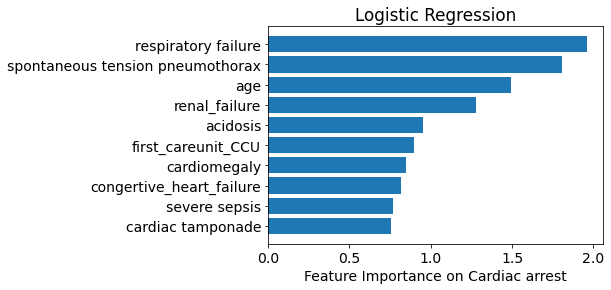

In [44]:
importance = logregCV.coef_[0]
sorted_idx_lr=importance.argsort()
top_10_lr=sorted_idx_lr[60:]
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh(df_column, importance[top_10_lr])
plt.title('Logistic Regression')
plt.xlabel("Feature Importance on Cardiac arrest")
plt.show()

In [21]:
df_train.columns

Index(['age', 'female', 'congestive_heart_failure', 'cardiac_arrhythmias',
       'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular',
       'uncomplicated_hypertension', 'complicated_hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression', 'mvar1', 'mvar2', 'mvar3',
       'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9', 'mvar10',
       'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23',
       'first_careunit_CCU', 'first_careunit_CVICU',
       'first_careunit_

[38 18 63 39 47 27 51 67 35 19 17 52 66 49 37 60 31 65 40  9 20 64 42 21
 30 22 24 53 36 43 58 28 69 48  4 68 13 14 46 61 62 12 11 23  0  6 25 16
 33 29  5 59  8 32 34 57 54  1 10 15 45  3 56  7 41 26  2 55 50 44]


Text(0.5, 0, 'Random Forest Feature Importance')

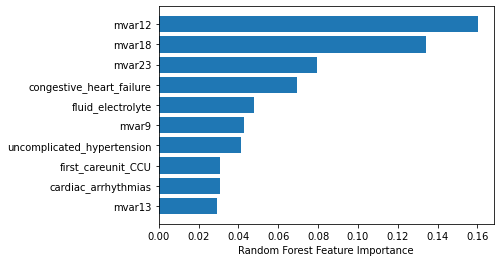

In [22]:
sorted_idx = forest_fit.best_estimator_.feature_importances_.argsort()
#print(importances)

print(sorted_idx)

#sorted_idx = forest.feature_importances_.argsort()

top_10=sorted_idx[60:]

plt.barh(df_train.columns[top_10], forest_fit.best_estimator_.feature_importances_[top_10])
plt.xlabel("Random Forest Feature Importance")



In [23]:
 forest_fit.best_estimator_.feature_importances_[top_10]

array([0.02918884, 0.03064228, 0.03085302, 0.04122551, 0.04267652,
       0.04775856, 0.06919483, 0.07950337, 0.13401993, 0.16002965])

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [25]:
nei_test_y_predicted = neigh.predict(X_test)
predict_test=[]
for i in range(nei_test_y_predicted.shape[0]): 
    if nei_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.944465
Sensitivity : 0.22
Specificity :0.96


predict,0,1
label,,
0,5064,225
1,74,21


In [26]:
from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm = svm.SVC(probability=True) 
svm.fit(X_train,y_train)
svm_y_predicted = svm.predict(X_test)

In [27]:
svm_y_predicted_pro = svm.predict_proba(X_test)

In [28]:
svm_score=svm_y_predicted_pro[:,1]

In [29]:
predict_test=[]
for i in range(svm_score.shape[0]): 
    if svm_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.979383
Sensitivity : 0.08
Specificity :1.00


predict,0,1
label,,
0,5265,24
1,87,8


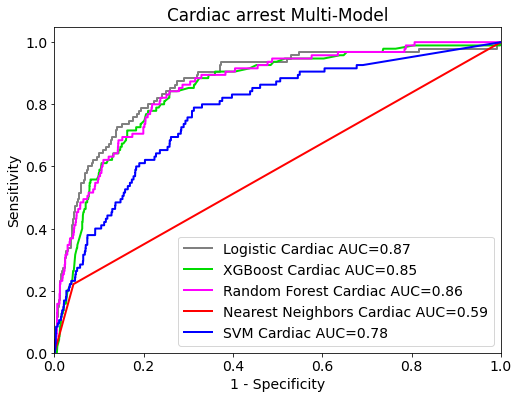

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

#plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_score_CV)
plt.plot(fpr, tpr, color='gray', lw=2,
         label='Logistic Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xg)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='XGBoost Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#ff00ff', lw=2,
         label='Random Forest Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)
plt.plot(fpr, tpr, color='red', lw=2,
         label='Nearest Neighbors Cardiac AUC={0:.2f}'.format(roc_auc))


fpr, tpr, roc_auc = roc_curve_and_score(y_test, svm_score)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SVM Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Cardiac arrest Multi-Model')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [31]:
print('label:',y_test.shape)

label: (5384,)


Original ROC area: 0.738
Confidence interval for the score: [0.696 - 0.782]


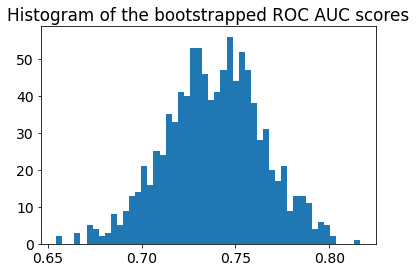

In [32]:
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test,y_pred)))
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)
   # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

AUC : 0.78
Sensitivity : 0.08
Specificity :1.00
Original ROC area: 0.858
Confusion Matrix : 
 [[4943  346]
 [  48   47]]
AUC : 0.78
Sensitivity : 0.49
Specificity :0.93
Confidence interval for the score: [0.825 - 0.885]


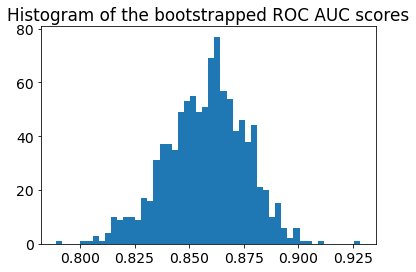

In [33]:
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test,y_score)))
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_score), len(y_score))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_score[indices])
    bootstrapped_scores.append(score)
   # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(5384)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [34]:
def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics
# Model A (random) vs. "good" model B
#preds_A = np.array([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
#preds_B = np.array([.2, .5, .1, .4, .9, .8, .7, .5, .9, .8])
#actual= np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1])
preds_A = y_pred
preds_B = y_score
actual= y_test
def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y
X_A, Y_A = group_preds_by_label(preds_A, actual)
X_B, Y_B = group_preds_by_label(preds_B, actual)
V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)
auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)
# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
         + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
         + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
            + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
p = st.norm.sf(abs(z))*2

print(p)


7.173966234728389e-09


[38 18 63 39 47 27 51 67 35 19 17 52 66 49 37 60 31 65 40  9 20 64 42 21
 30 22 24 53 36 43 58 28 69 48  4 68 13 14 46 61 62 12 11 23  0  6 25 16
 33 29  5 59  8 32 34 57 54  1 10 15 45  3 56  7 41 26  2 55 50 44]


Text(0.5, 0, 'Random Forest Feature Importance')

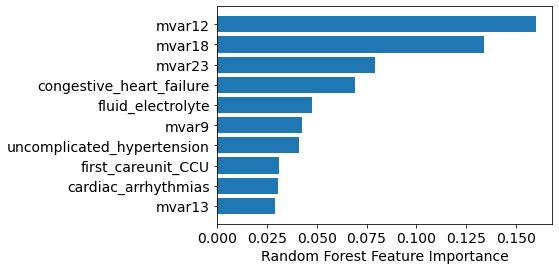

In [36]:
sorted_idx = forest_fit.best_estimator_.feature_importances_.argsort()
#print(importances)

print(sorted_idx)

#sorted_idx = forest.feature_importances_.argsort()

top_10=sorted_idx[60:]

plt.barh(df_train.columns[top_10], forest_fit.best_estimator_.feature_importances_[top_10])
plt.xlabel("Random Forest Feature Importance")



In [45]:
df_train.columns[top_10]

Index(['mvar13', 'cardiac_arrhythmias', 'first_careunit_CCU',
       'uncomplicated_hypertension', 'mvar9', 'fluid_electrolyte',
       'congestive_heart_failure', 'mvar23', 'mvar18', 'mvar12'],
      dtype='object')